# Importations

In [2]:
from typing import List
from enum import Enum

import numpy as np
import pandas as pd

# Dataset sur lequel nous allons travailler

In [3]:
class DataType(Enum):
    BOOLEAN = 1
    QUALITATIVE_NOMINAL = 2         # Named categories : ['FH', 'SF', 'EV']
    QUALITATIVE_ORDINAL = 3         # Categories with an implied order : ['small', 'medium', 'high']
    QUANTITATIVE_DISCRETE = 4       # Only particular numbers : [1, 2, 3, 6, 8]
    QUANTITATIVE_CONTINUOUS = 5     # Any numerical value : [1.345, 2.394, 8.345, 0.432]
    LABEL = 6                       # Label de la classification


class JobWhenMissingValue(Enum):    # Si une valeur d'un dataset est manquante
    DELETE_LINE = 1                 # - On supprime la ligne
    REPLACE_VALUE = 2               # - On remplace la valeur

class EncodingType(Enum):
    ONE_HOT_ENCODER = 1
    ORDINAL_ENCODER = 2

In [4]:
# Url à partir de la racine du dataset au format CSV
CSV_FILE_URL: str = 'breast-cancer.csv'

# Si le fichier CSV contient les noms de colonnes, mettre à True, si le fichier CSV ne contient
# que les données, et pas les titres, mettre à False
IS_CSV_FILE_CONTAINS_ROW_HEADER: bool = False

# Renommer les noms des colonnes
NAMES_ROWS_HEADER: List[str] = [
    "class",
    "age",
    "menopause",
    "tumor-size",
    "inv-nodes",
    "node-caps",
    "deg-malig",
    "breast",
    "breast-quad",
    "irradiat",
]

# Les types des données qui ont été inséré
ROWS_DATATYPES = {
    "class": {
        "datatype": DataType.BOOLEAN,
        "possible_values": [ "recurrence-events", "no-recurrence-events" ], # TRUE, FALSE
        "job_when_missing_value": {
            "type": JobWhenMissingValue.REPLACE_VALUE,
            "replace_by": False,
        }
    },
    "age": {
        "datatype": DataType.QUALITATIVE_ORDINAL,
        "possible_values": [ "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-99" ],
        "encoding": EncodingType.ORDINAL_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "menopause": {
        "datatype": DataType.QUALITATIVE_NOMINAL,
        "possible_values": [ "lt40", "premeno", "ge40" ],
        "encoding": EncodingType.ONE_HOT_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "tumor-size": {
        "datatype": DataType.QUALITATIVE_ORDINAL,
        "possible_values": [ "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59" ],
        "encoding": EncodingType.ORDINAL_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "inv-nodes": {
        "datatype": DataType.QUALITATIVE_ORDINAL,
        "possible_values": [ "0-2", "3-5", "6-8", "9-11", "12-14", "15-17", "18-20", "21-23", "24-26", "27-29", "30-32", "33-35", "36-39" ],
        "encoding": EncodingType.ORDINAL_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "node-caps": {
        "datatype": DataType.BOOLEAN,
        "possible_values": ["yes", "no"],
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "deg-malig": {
        "datatype": DataType.QUANTITATIVE_DISCRETE,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "breast": {
        "datatype": DataType.QUALITATIVE_NOMINAL,
        "possible_values": [ "left", "right" ],
        "encoding": EncodingType.ONE_HOT_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "breast-quad": {
        "datatype": DataType.QUALITATIVE_NOMINAL,
        "possible_values": [ "left_up",  "left_low",  "right_up",  "right_low",  "central" ],
        "encoding": EncodingType.ONE_HOT_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "irradiat": {
        "datatype": DataType.LABEL,
        "possible_values": ["yes", "no"],
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
}

In [5]:

def load_dataset() -> pd.DataFrame:

    header_value = 1 if IS_CSV_FILE_CONTAINS_ROW_HEADER else None

    current_dataset = pd.read_csv(CSV_FILE_URL, header= header_value)

    if header_value is None:
        current_dataset.columns = NAMES_ROWS_HEADER

    return current_dataset

current_dataset = load_dataset()

# Pré-processing

## Nettoyage des données

Cela consiste à enlever les données manquantes ou erronées et à corriger les erreurs éventuelles.

In [19]:
def clean_dataset(dataframe: pd.DataFrame, parameters: dict) -> pd.DataFrame:
    """ Méthode qui nettoie le dataset selon les volontés définies par le client dans `parameters`
    :param dataframe: pd.DataFrame = notre dataset
    :param parameters: dict = notre dictionnaire ROWS_DATATYPES
    """
    dataframe = dataframe.replace("?", np.nan)

    for key, value in parameters.items():

        if value["job_when_missing_value"]["type"] == JobWhenMissingValue.DELETE_LINE:
            dataframe = dataframe[dataframe[key].notna()]

        if value["job_when_missing_value"]["type"] == JobWhenMissingValue.REPLACE_VALUE:
            dataframe[key] = dataframe[key].replace(np.nan, value["job_when_missing_value"]["replace_by"])


    return dataframe.reset_index()

current_dataset = load_dataset()
clean_dataset(current_dataset, ROWS_DATATYPES)

,index,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...,...
272,281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
273,282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
274,283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
275,284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


## Normalisation des données (uniquement pour les données quantitatives)

Cela consiste à mettre toutes les données sur la même échelle, afin d'éviter que certains attributs aient un poids plus important que d'autres dans l'analyse.

In [7]:
from sklearn.preprocessing import minmax_scale

def normalize_dataset(dataframe: pd.DataFrame, parameters: dict) -> pd.DataFrame:
    """
    :param dataframe:
    :param parameters:
    :return:
    """
    for key, value in parameters.items():

        if value["datatype"] == DataType.QUANTITATIVE_DISCRETE or value["datatype"] == DataType.QUANTITATIVE_CONTINUOUS:

            dataframe[[key]] = minmax_scale(dataframe[[key]])

    return dataframe

current_dataset = load_dataset()
normalize_dataset(current_dataset, ROWS_DATATYPES)

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,1.0,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,0.5,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,0.5,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,0.5,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,0.5,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,0.5,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,1.0,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,0.0,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,1.0,left,left_low,no


## Transformation des données

Cela consiste à appliquer des transformations mathématiques aux données afin de les mettre sous une forme qui convient mieux à l'analyse. Par exemple, il peut être utile de transformer des données catégorielles en données numériques.

In [20]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

def transform_data(dataframe: pd.DataFrame, parameters: dict) -> pd.DataFrame:
    """
    "datatype": DataType.QUALITATIVE_ORDINAL,
        "possible_values": [ "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-99" ],
        "encoding": EncodingType.ORDINAL_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
    }
    """

    for key, value in parameters.items():
        if value["datatype"] == DataType.BOOLEAN:
            remplacement = {
                value["possible_values"][0]: True,
                value["possible_values"][1]: False
            }

            dataframe[key] = dataframe[key].map(remplacement)

        if "encoding" in value and value["encoding"] == EncodingType.ORDINAL_ENCODER:
            # Création de l'objet OrdinalEncoder
            ordinal_encoder = OrdinalEncoder(categories=[value["possible_values"]])

            # Encodage des valeurs de la colonne
            dataframe[key] = ordinal_encoder.fit_transform(dataframe[[key]])

        if "encoding" in value and value["encoding"] == EncodingType.ONE_HOT_ENCODER:
            # Création de l'objet OneHotEncoder
            one_hot_encoder = OneHotEncoder(categories=[value["possible_values"]])

            # Encodage des valeurs de la colonne
            values_encoded = one_hot_encoder.fit_transform(dataframe[[key]]).toarray()

            dataframe = dataframe.drop(key, axis=1)

            dataframe_encoded = pd.DataFrame(values_encoded, columns=[f"{key}_{x}" for x in one_hot_encoder.categories_[0]])
            dataframe = dataframe.join(dataframe_encoded)



    return dataframe

current_dataset = load_dataset()
current_dataset = clean_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = normalize_dataset(current_dataset, ROWS_DATATYPES)
transform_data(current_dataset, ROWS_DATATYPES)

,index,class,age,tumor-size,inv-nodes,node-caps,deg-malig,irradiat,menopause_lt40,menopause_premeno,menopause_ge40,breast_left,breast_right,breast-quad_left_up,breast-quad_left_low,breast-quad_right_up,breast-quad_right_low,breast-quad_central
0,0,False,2.0,6.0,0.0,False,1.0,no,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,False,3.0,4.0,0.0,False,0.5,no,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2,False,3.0,4.0,0.0,False,0.5,no,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,False,5.0,3.0,0.0,False,0.5,no,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,4,False,3.0,0.0,0.0,False,0.5,no,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,281,True,2.0,6.0,0.0,False,0.5,no,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
273,282,True,2.0,4.0,0.0,False,1.0,yes,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
274,283,True,5.0,4.0,0.0,False,0.0,no,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
275,284,True,3.0,6.0,1.0,False,1.0,no,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


# Split des données

In [9]:
from sklearn.model_selection import train_test_split

def split_datas(dataframe: pd.DataFrame, parameters: dict):

    label_column_name = None

    for key, value in parameters.items():
        if value["datatype"] == DataType.LABEL:
            label_column_name = key

    if label_column_name is None:
        raise ValueError("Cannot find the label column")

    y = dataframe[label_column_name]
    X = dataframe.drop(label_column_name, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

current_dataset = load_dataset()
current_dataset = clean_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = normalize_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = transform_data(current_dataset, ROWS_DATATYPES)

split_datas(current_dataset, ROWS_DATATYPES)

(     class  age  tumor-size  inv-nodes  node-caps  deg-malig  menopause_lt40  \
 270   True  4.0         6.0        2.0       True        1.0             0.0   
 116  False  2.0         3.0        0.0      False        0.0             0.0   
 196  False  4.0         2.0        1.0      False        0.0             0.0   
 74   False  2.0         1.0        0.0      False        0.5             0.0   
 5    False  5.0         3.0        0.0      False        0.5             0.0   
 ..     ...  ...         ...        ...        ...        ...             ...   
 282   True  2.0         4.0        0.0      False        1.0             NaN   
 115  False  4.0         4.0        0.0      False        0.5             0.0   
 141  False  4.0         4.0        1.0       True        0.5             0.0   
 72   False  5.0         4.0        0.0      False        0.5             0.0   
 151  False  5.0         6.0        1.0       True        1.0             0.0   
 
      menopause_premeno  m

# Classification

- Arbres de décision : l'algorithme de décision arbre (DecisionTreeClassifier) permet de créer un modèle de classification en utilisant une structure de décision hiérarchique basée sur les caractéristiques du jeu de données.

- Forêts aléatoires : l'algorithme de forêt aléatoire (RandomForestClassifier) est une extension de l'algorithme de décision arbre qui crée un ensemble de arbres de décision et utilise la moyenne de leurs prédictions pour améliorer la robustesse du modèle.

- Réseaux de neurones : l'algorithme de réseau de neurones (MLPClassifier) est un algorithme de classification basé sur l'apprentissage profond qui utilise une architecture de réseau de neurones pour effectuer la classification.

- SVM (Support Vector Machines) : l'algorithme SVM (SVC) est un algorithme de classification qui utilise des hyperplans de séparation pour séparer les différentes classes dans l'espace des features.

- K-mean : l'algorithme KNN (KNeighborsClassifier) est un algorithme de classification qui prédit la classe d'une observation en utilisant la classe majoritaire des K observations les plus proches de cette observation.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def evaluate_classifiers(X_train, y_train, X_val, y_val):
    # Création d'une instance de chaque algorithme de classification
    tree_clf = DecisionTreeClassifier()
    forest_clf = RandomForestClassifier()
    neural_net_clf = MLPClassifier()
    svm_clf = SVC()
    knn_clf = KNeighborsClassifier()

    # Entraînement de chaque algorithme sur les données d'entraînement
    tree_clf.fit(X_train, y_train)
    forest_clf.fit(X_train, y_train)
    neural_net_clf.fit(X_train, y_train)
    svm_clf.fit(X_train, y_train)
    knn_clf.fit(X_train, y_train)

    # Évaluation de la performance de chaque algorithme sur les données de validation
    tree_predictions = tree_clf.predict(X_val)
    forest_predictions = forest_clf.predict(X_val)
    neural_net_predictions = neural_net_clf.predict(X_val)
    svm_predictions = svm_clf.predict(X_val)
    knn_predictions = knn_clf.predict(X_val)

    # Calcul de l'accuracy de chaque algorithme
    tree_accuracy = accuracy_score(y_val, tree_predictions)
    forest_accuracy = accuracy_score(y_val, forest_predictions)
    neural_net_accuracy = accuracy_score(y_val, neural_net_predictions)
    svm_accuracy = accuracy_score(y_val, svm_predictions)
    knn_accuracy = accuracy_score(y_val, knn_predictions)

    print(f"tree_accuracy : {tree_accuracy}")
    print(f"forest_accuracy : {forest_accuracy}")
    print(f"neural_net_accuracy : {neural_net_accuracy}")
    print(f"svm_accuracy : {svm_accuracy}")
    print(f"knn_accuracy : {knn_accuracy}")


current_dataset = load_dataset()
current_dataset = clean_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = normalize_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = transform_data(current_dataset, ROWS_DATATYPES)

X_train, y_train, X_val, y_val, X_test, y_test = split_datas(current_dataset, ROWS_DATATYPES)
evaluate_classifiers(X_train, y_train, X_val, y_val)

tree_accuracy : 0.6785714285714286
forest_accuracy : 0.6964285714285714
neural_net_accuracy : 0.75
svm_accuracy : 0.7142857142857143
knn_accuracy : 0.7142857142857143


/Users/williamdandrea/config/virtual_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [25]:
CLASSIFIERS_CONFIG = [
    DecisionTreeClassifier(criterion="gini", splitter="best", ),
    RandomForestClassifier(n_estimators=200),
    MLPClassifier(activation="relu"),
    SVC(C=1.2),
    KNeighborsClassifier(n_neighbors=6),
]


def launch_analysis(X_train, y_train, X_val, y_val, CLASSIFIERS_CONFIG):

    results = {}

    for classifier in CLASSIFIERS_CONFIG:
        classifier.fit(X_train, y_train)
        prediction = classifier.predict(X_val)
        score = accuracy_score(y_val, prediction)

        results[f"{classifier}"] = {
            "score": score,
            "trained_classifier": classifier
        }

    return results


current_dataset = load_dataset()
current_dataset = clean_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = normalize_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = transform_data(current_dataset, ROWS_DATATYPES)

X_train, y_train, X_val, y_val, X_test, y_test = split_datas(current_dataset, ROWS_DATATYPES)
launch_analysis(X_train, y_train, X_val, y_val, CLASSIFIERS_CONFIG)

/Users/williamdandrea/config/virtual_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'DecisionTreeClassifier()': {'score': 0.7321428571428571,
  'trained_classifier': DecisionTreeClassifier()},
 'RandomForestClassifier(n_estimators=200)': {'score': 0.6607142857142857,
  'trained_classifier': RandomForestClassifier(n_estimators=200)},
 'MLPClassifier()': {'score': 0.75, 'trained_classifier': MLPClassifier()},
 'SVC(C=1.2)': {'score': 0.7142857142857143, 'trained_classifier': SVC(C=1.2)},
 'KNeighborsClassifier(n_neighbors=6)': {'score': 0.6964285714285714,
  'trained_classifier': KNeighborsClassifier(n_neighbors=6)}}

In [27]:
def launch_test(analysis_results, X_test, y_test):

    for key, value in analysis_results.items():
        trained_classifier = value["trained_classifier"]

        print(f"{key} => {value['score']} | {accuracy_score(y_test, trained_classifier.predict(X_test))}")

current_dataset = load_dataset()
current_dataset = clean_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = normalize_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = transform_data(current_dataset, ROWS_DATATYPES)

X_train, y_train, X_val, y_val, X_test, y_test = split_datas(current_dataset, ROWS_DATATYPES)
analysis_results = launch_analysis(X_train, y_train, X_val, y_val, CLASSIFIERS_CONFIG)

launch_test(analysis_results, X_test, y_test)

DecisionTreeClassifier() => 0.6964285714285714 | 0.7321428571428571
RandomForestClassifier(n_estimators=200) => 0.7142857142857143 | 0.7857142857142857
MLPClassifier() => 0.7142857142857143 | 0.7857142857142857
SVC(C=1.2) => 0.7142857142857143 | 0.8392857142857143
KNeighborsClassifier(n_neighbors=6) => 0.6964285714285714 | 0.7857142857142857


/Users/williamdandrea/config/virtual_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Test avec plusieurs hyperparametres pour chaque algo


Best score: 0.78 | Validation score : 0.7142857142857143 | Test score : 0.7321428571428571


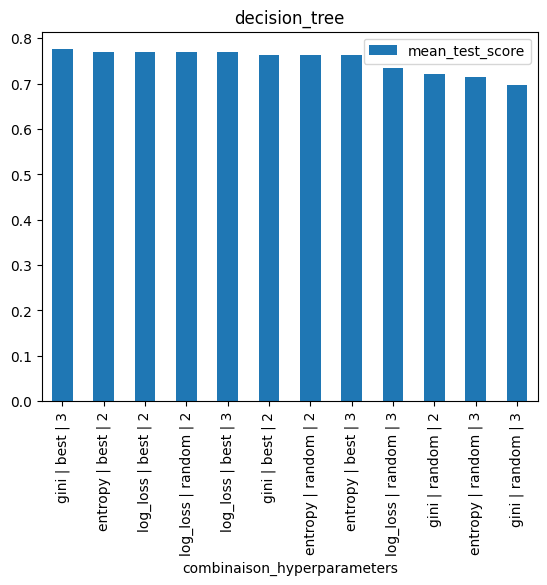

Best score: 0.82 | Validation score : 0.6785714285714286 | Test score : 0.75


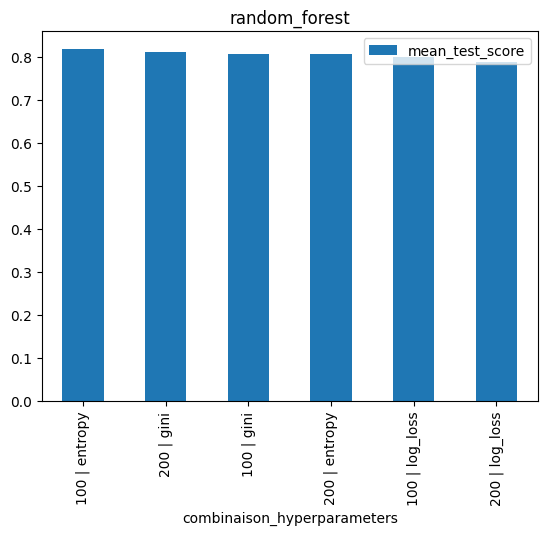

/Users/williamdandrea/config/virtual_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/williamdandrea/config/virtual_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/williamdandrea/config/virtual_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: C

Best score: 0.78 | Validation score : 0.75 | Test score : 0.7857142857142857


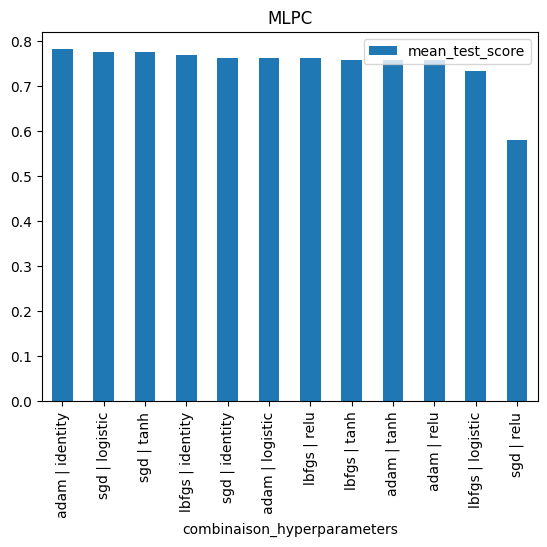

Best score: 0.78 | Validation score : 0.7142857142857143 | Test score : 0.8392857142857143


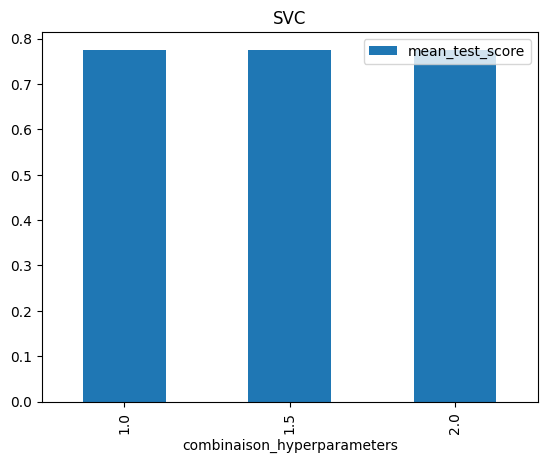

Best score: 0.79 | Validation score : 0.6964285714285714 | Test score : 0.7857142857142857


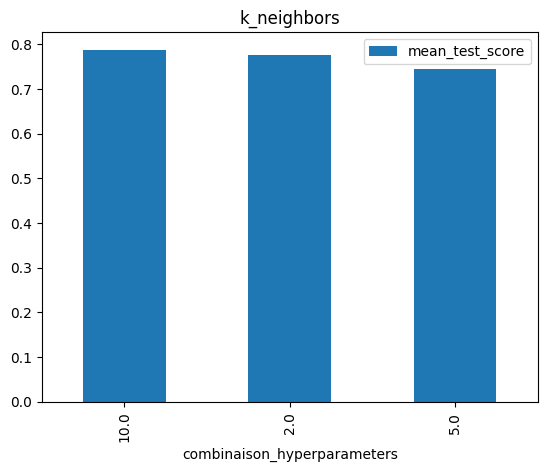

In [77]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

CLASSIFIERS_CONFIGURATION = {
    "decision_tree": {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "min_samples_split": [2, 3]
    },
    "random_forest": {
        "n_estimators": [100, 200],
        "criterion": ["gini", "entropy", "log_loss"],
    },
    "MLPC": {
        "solver": ['lbfgs', 'sgd', 'adam'],
        "activation" : ['identity', 'logistic', 'tanh', 'relu']
    },
    "SVC": {
        "C": [1.0, 1.5, 2.0]
    },
    "k_neighbors": {
        "n_neighbors": [2, 5, 10]
    }
}

# classifier.fit(X_train, y_train)
# prediction = classifier.predict(X_val)
# score = accuracy_score(y_val, prediction)

def plot_bar_chart(name_cls, df, y_col, label_col):
    # Créez une colonne qui concatène les valeurs de `label_col`
    df['combinaison_hyperparameters'] = df[label_col].apply(lambda x: " | ".join(map(str, x)), axis=1)

    ax = df.plot(x='combinaison_hyperparameters', y=y_col, kind='bar', title=name_cls)

    # Afficher le graphique
    plt.show()

def launch_analysis_complete(X_train, y_train, X_val, y_val, X_test, y_test, configuration):

    for name_cls, optimizations_values in configuration.items():

        clf = None

        if name_cls == "decision_tree":
            clf = DecisionTreeClassifier()

        if name_cls == "random_forest":
            clf = RandomForestClassifier()

        if name_cls == "MLPC":
            clf = MLPClassifier()

        if name_cls == "SVC":
            clf = SVC()

        if name_cls == "k_neighbors":
            clf = KNeighborsClassifier()


        # Initialisez la recherche de grille
        grid_search = GridSearchCV(estimator=clf, param_grid=optimizations_values, cv=5)

        # Entraînez votre modèle en utilisant la recherche de grille
        grid_search.fit(X_train, y_train)

        best_score = grid_search.best_score_
        print(f'Best score: {best_score:.2f} '
              f'| Validation score : {grid_search.score(X_val, y_val)} '
              f'| Test score : {grid_search.score(X_test, y_test)}')

        # Récupérez les résultats de la recherche de grille
        results = grid_search.cv_results_

        results_dataframe = []
        columns_name = []
        for param, possible_values in optimizations_values.items():
            results_dataframe.append(results[f'param_{param}'].data)
            columns_name.append(f"{param}")
        results_dataframe.append(results['mean_test_score'])
        columns_name.append("mean_test_score")

        results_dataframe = pd.DataFrame(results_dataframe).T
        results_dataframe = results_dataframe.reset_index(drop=True)
        results_dataframe.columns = columns_name
        results_dataframe = results_dataframe.sort_values(by=['mean_test_score'], ascending=False)
        columns_name.remove("mean_test_score")

        plot_bar_chart(name_cls, results_dataframe, 'mean_test_score', columns_name)


current_dataset = load_dataset()
current_dataset = clean_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = normalize_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = transform_data(current_dataset, ROWS_DATATYPES)

X_train, y_train, X_val, y_val, X_test, y_test = split_datas(current_dataset, ROWS_DATATYPES)
launch_analysis_complete(X_train, y_train, X_val, y_val, X_test, y_test, CLASSIFIERS_CONFIGURATION)